## 1. Import libraries

In [61]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

In [62]:
df = pd.read_csv('data/cleaned_chicken_market_study_data.csv', sep=',')
df.head()

,Country Name,Country Code,Total Population,Access to Electricity (%),Population Growth Rate,Urban Population Growth Rate,Urban Population,Political Stability Index,Regulatory Quality Index,Logistics Performance Index,GDP per Capita Growth (%),GDP per Capita (current US$),Chicken Meat Production (kg),Import Quantity (kg),Export Quantity (kg),Poultry Consumption (kg),Import Dependency Ratio,Self-Sufficiency Ratio,Poultry Consumption Growth Potential
0,Afghanistan,AFG,40578842.0,85.3,1.435704,2.576854,10800465.0,-2.544956,-1.271806,1.9,-7.576669,357.261153,2.850314e+07,6902310.0,56040.0,3.578203e+07,19.525955,80.632576,9.220507e+07
1,Angola,AGO,35635029.0,48.5,3.143026,4.059358,24260684.0,-0.630109,-0.606699,2.1,-0.143628,2929.694455,5.717738e+07,308122710.0,10870.0,3.743962e+08,84.350343,15.652633,1.519808e+09
2,United Arab Emirates,ARE,10074977.0,100.0,5.088342,5.367449,8819937.0,0.744183,1.034781,4.0,2.176083,49899.065298,4.700000e+07,615447940.0,94007430.0,5.131117e+08,108.269543,8.268235,2.754101e+09
3,Argentina,ARG,45407904.0,100.0,0.210809,0.338668,41932837.0,-0.098594,-0.697566,2.8,5.048195,13935.681111,2.319469e+09,10218320.0,179621830.0,2.193142e+09,0.475256,107.878993,7.427477e+08
4,Armenia,ARM,2969200.0,100.0,0.232656,0.456271,1887610.0,-0.740756,-0.019079,2.5,12.338334,6571.974455,1.410000e+07,37595230.0,192800.0,5.287238e+07,72.997002,27.377349,2.412414e+07


## 2. PCA: Dimensionality Reduction for Market Indicators
We will standardize selected numeric indicators, run PCA to reduce dimensionality, examine explained variance, visualize the 2D projection (PC1 vs PC2), and inspect feature loadings to interpret principal components.

### Features selection and scaling

In [63]:
# Select numeric features for PCA
numeric_cols = [
       'Access to Electricity (%)', 
       'Urban Population',
       'Political Stability Index', 'Regulatory Quality Index',
       'Logistics Performance Index',
       'GDP per Capita (current US$)', 'Chicken Meat Production (kg)',
       'Poultry Consumption (kg)', 'Import Dependency Ratio',
       'Self-Sufficiency Ratio', 'Poultry Consumption Growth Potential']

# Keep only columns that actually exist
numeric_cols = [c for c in numeric_cols if c in df.columns]
print('Using features for PCA:', numeric_cols)

# Filter data and drop rows with missing values in these columns
X = df[numeric_cols].copy()
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()

# Keep aligned country identifiers for later plots
id_cols = [c for c in ['Country or Area', 'Country Code'] if c in df.columns]
ids = df.loc[X.index, id_cols].copy() if id_cols else None

# Standardize features (using StandardScaler imported above)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Shape after cleaning:', X.shape)

Using features for PCA: ['Access to Electricity (%)', 'Urban Population', 'Political Stability Index', 'Regulatory Quality Index', 'Logistics Performance Index', 'GDP per Capita (current US$)', 'Chicken Meat Production (kg)', 'Poultry Consumption (kg)', 'Import Dependency Ratio', 'Self-Sufficiency Ratio', 'Poultry Consumption Growth Potential']
Shape after cleaning: (104, 11)


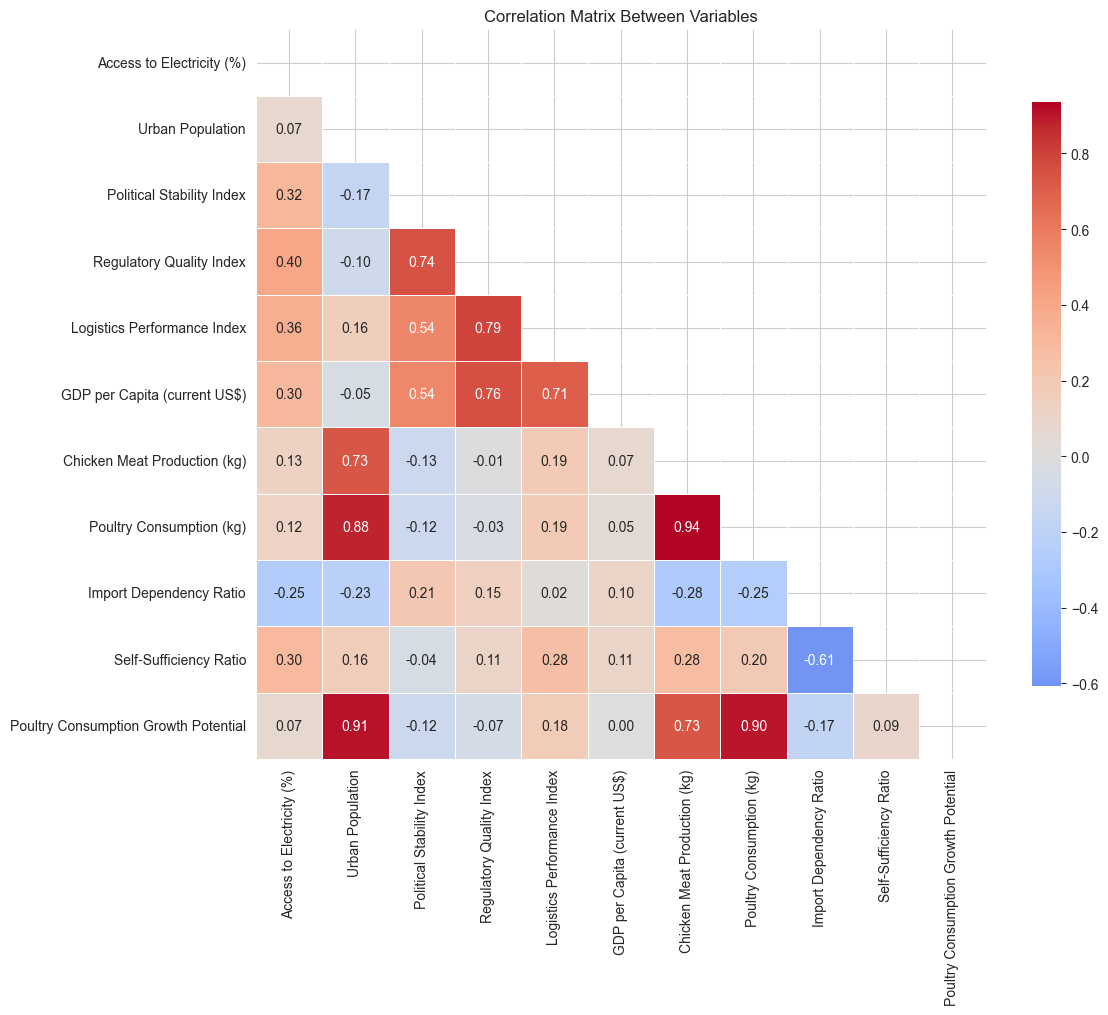

Urban Population ↔ Chicken Meat Production (kg): 0.73
Urban Population ↔ Poultry Consumption (kg): 0.88
Urban Population ↔ Poultry Consumption Growth Potential: 0.91
Political Stability Index ↔ Regulatory Quality Index: 0.74
Regulatory Quality Index ↔ Logistics Performance Index: 0.79
Regulatory Quality Index ↔ GDP per Capita (current US$): 0.76
Logistics Performance Index ↔ GDP per Capita (current US$): 0.71
Chicken Meat Production (kg) ↔ Poultry Consumption (kg): 0.94
Chicken Meat Production (kg) ↔ Poultry Consumption Growth Potential: 0.73
Poultry Consumption (kg) ↔ Poultry Consumption Growth Potential: 0.90


In [64]:
# Correlation matrix
correlation_matrix = X.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix Between Variables')
plt.tight_layout()
plt.show()

# High correlations
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            print(f"{correlation_matrix.columns[i]} ↔ {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.2f}")

### Scree Plot

Explained variance ratio per component:
[0.3482 0.2993 0.1441 0.0636 0.0392 0.0331 0.0315 0.0201 0.0116 0.0077
 0.0016]

Cumulative explained variance:
[0.3482 0.6475 0.7916 0.8552 0.8944 0.9275 0.959  0.9791 0.9907 0.9984
 1.    ]


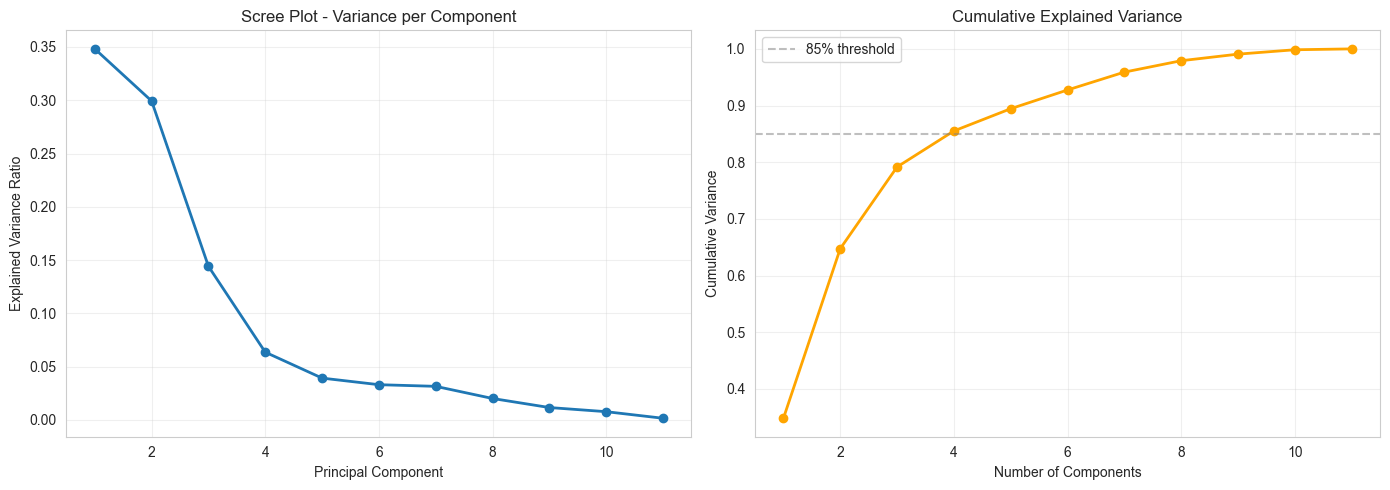


Summary: Determining optimal number of components
60% variance explained by: 2 components
70% variance explained by: 3 components
80% variance explained by: 4 components
90% variance explained by: 6 components


In [65]:
# Fit PCA on standardized data
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance analysis
explained_var = pca.explained_variance_ratio_
print('Explained variance ratio per component:')
print(np.round(explained_var, 4))
print('\nCumulative explained variance:')
cumsum_var = np.cumsum(explained_var)
print(np.round(cumsum_var, 4))

# Combined Scree Plot and Cumulative Variance visualization
fig, (ax_scree, ax_cumsum) = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
ax_scree.plot(range(1, len(explained_var)+1), explained_var, marker='o', linewidth=2)
ax_scree.set_title('Scree Plot - Variance per Component')
ax_scree.set_xlabel('Principal Component')
ax_scree.set_ylabel('Explained Variance Ratio')
ax_scree.grid(True, alpha=0.3)

# Cumulative variance
ax_cumsum.plot(range(1, len(explained_var)+1), cumsum_var, marker='o', color='orange', linewidth=2)
ax_cumsum.axhline(y=0.85, color='gray', linestyle='--', alpha=0.5, label='85% threshold')
ax_cumsum.set_title('Cumulative Explained Variance')
ax_cumsum.set_xlabel('Number of Components')
ax_cumsum.set_ylabel('Cumulative Variance')
ax_cumsum.legend()
ax_cumsum.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSummary: Determining optimal number of components")
for threshold in [0.60, 0.70, 0.80, 0.90]:
    n_comp = np.argmax(cumsum_var >= threshold) + 1
    print(f"{threshold:.0%} variance explained by: {n_comp} components")

visually we can see that first 4 components explain most of the variance, however we will try to examine statistically significant components using permutation test below.

Kaiser criterion (eigenvalue > 1): 3 components → 79.2% variance


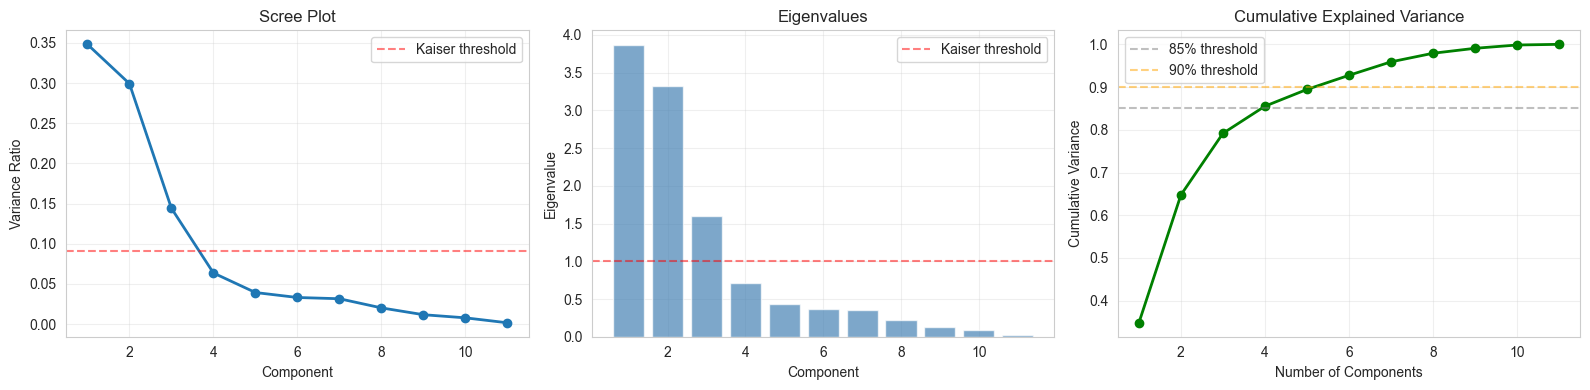

In [66]:
# Statistical analysis of component selection
eigenvalues = pca.explained_variance_

# Kaiser criterion (eigenvalue > 1)
kaiser_n = (eigenvalues > 1).sum()
print(f"Kaiser criterion (eigenvalue > 1): {kaiser_n} components → {cumsum_var[kaiser_n-1]:.1%} variance")

# Broken stick model
def broken_stick(n):
    """Calculate broken stick threshold for PCA component selection"""
    return np.array([sum(1/np.arange(i, n+1)) for i in range(1, n+1)]) / n

bs = broken_stick(len(eigenvalues))
broken_stick_n = (explained_var > bs).sum()

# Comprehensive visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Left: Scree plot with Kaiser threshold
axes[0].plot(range(1, len(explained_var)+1), explained_var, 'o-', linewidth=2, markersize=6)
axes[0].axhline(y=1/len(explained_var), color='r', linestyle='--', alpha=0.5, label='Kaiser threshold')
axes[0].set_title('Scree Plot')
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Variance Ratio')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Middle: Eigenvalues comparison
axes[1].bar(range(1, len(eigenvalues)+1), eigenvalues, alpha=0.7, color='steelblue')
axes[1].axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Kaiser threshold')
axes[1].set_title('Eigenvalues')
axes[1].set_xlabel('Component')
axes[1].set_ylabel('Eigenvalue')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Right: Cumulative variance with thresholds
axes[2].plot(range(1, len(cumsum_var)+1), cumsum_var, 'o-', linewidth=2, color='green', markersize=6)
axes[2].axhline(y=0.85, color='gray', linestyle='--', alpha=0.5, label='85% threshold')
axes[2].axhline(y=0.90, color='orange', linestyle='--', alpha=0.5, label='90% threshold')
axes[2].set_title('Cumulative Explained Variance')
axes[2].set_xlabel('Number of Components')
axes[2].set_ylabel('Cumulative Variance')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

While Kaiser criterion suggests keeping 3 components based on eigenvalues greater than 1,
we chose to proceed with 2 components (PC1 and PC2) for better interpretability and visualization.
This trade-off sacrifices a small amount of explained variance for the significant benefit of
being able to create clear 2D visualizations and easier business interpretation of market segments.
PC1 and PC2 together still capture the majority of variance and provide meaningful insights.

Correlation between Variables and Principal Components:
                                        PC1    PC2
Access to Electricity (%)             0.273  0.491
Urban Population                      0.894 -0.212
Political Stability Index            -0.055  0.816
Regulatory Quality Index              0.092  0.944
Logistics Performance Index           0.355  0.822
GDP per Capita (current US$)          0.154  0.833
Chicken Meat Production (kg)          0.899 -0.115
Poultry Consumption (kg)              0.958 -0.148
Import Dependency Ratio              -0.399  0.155
Self-Sufficiency Ratio                0.396  0.139
Poultry Consumption Growth Potential  0.889 -0.175


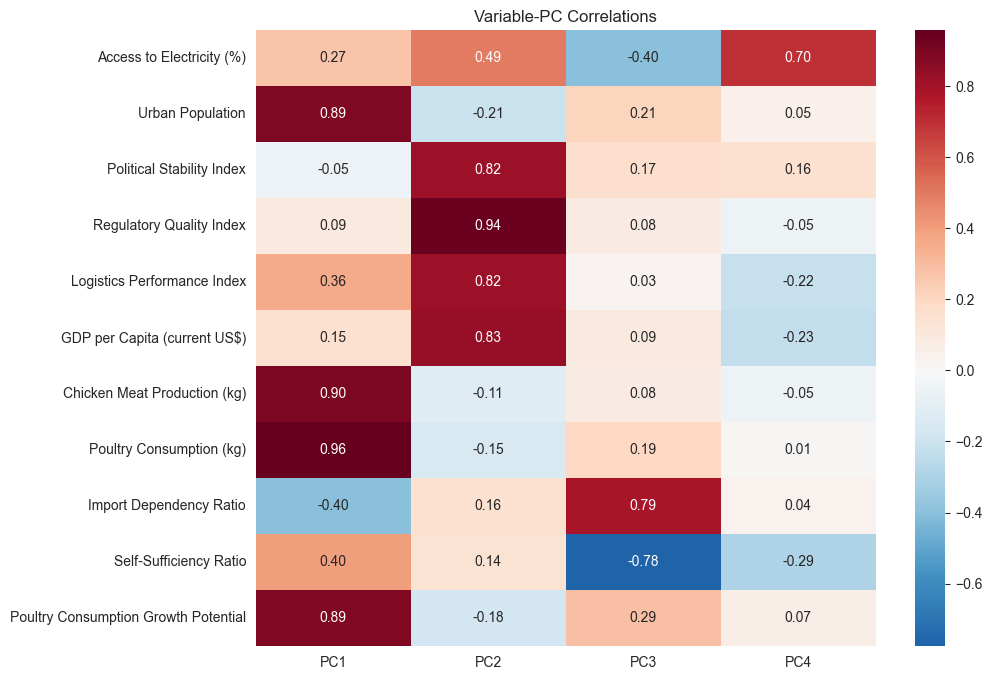

In [67]:
# Correlation between original variables and Principal Components
pca_corr = pd.DataFrame(
    pca.components_.T * np.sqrt(pca.explained_variance_),
    columns=[f'PC{i+1}' for i in range(len(numeric_cols))],
    index=numeric_cols
)

print("Correlation between Variables and Principal Components:")
print(pca_corr.iloc[:, :2].round(3))  # First 2 PCs

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(pca_corr.iloc[:, :4], annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Variable-PC Correlations')
plt.show()

### PCA visualization in 2D

In [68]:
# 2D PCA Visualization with Market Segmentation
pc = 2
pca_2 = PCA(n_components=pc)
X_pca_2 = pca_2.fit_transform(X_scaled)

# Prepare DataFrame with PCs and country identifiers
pc_cols = [f'PC{i+1}' for i in range(pc)]
df_pca = pd.DataFrame(X_pca_2, columns=pc_cols, index=X.index)
if ids is not None:
    df_pca = pd.concat([ids.reset_index(drop=True), df_pca.reset_index(drop=True)], axis=1)

# Create interactive scatter plot with market segmentation
fig = px.scatter(df_pca, 
                x='PC1', 
                y='PC2',
                hover_data=['Country Code'] if 'Country Code' in df_pca.columns else None,
                title='Interactive PCA: Chicken Market Analysis - Market Segmentation',
                labels={
                    'PC1': 'PC1 - Market Size Factor (Production, Consumption, Trade)',
                    'PC2': 'PC2 - Economic Development Factor (GDP, Stability, Logistics)'
                })

# Enhanced hover information
fig.update_traces(
    hovertemplate='<b>%{hovertext}</b><br>' +
                  'Market Size (PC1): %{x:.2f}<br>' +
                  'Economic Development (PC2): %{y:.2f}' +
                  '<extra></extra>',
    hovertext=df_pca['Country Code'] if 'Country Code' in df_pca.columns else df_pca.index,
    marker=dict(size=8)
)

# Add quadrant lines for market segmentation
fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
fig.add_vline(x=0, line_dash="dash", line_color="gray", opacity=0.5)

# Add quadrant labels with market interpretations
fig.add_annotation(x=2, y=2, text="<b>Premium Markets</b><br>(Large & Developed)", 
                  showarrow=False, bgcolor="lightblue", opacity=0.8, font=dict(size=10))
fig.add_annotation(x=2, y=-2, text="<b>Volume Markets</b><br>(Large & Developing)", 
                  showarrow=False, bgcolor="lightgreen", opacity=0.8, font=dict(size=10))
fig.add_annotation(x=-2, y=2, text="<b>Niche Markets</b><br>(Small & Developed)", 
                  showarrow=False, bgcolor="lightyellow", opacity=0.8, font=dict(size=10))
fig.add_annotation(x=-2, y=-2, text="<b>Emerging Markets</b><br>(Small & Developing)", 
                  showarrow=False, bgcolor="lightcoral", opacity=0.8, font=dict(size=10))

fig.update_layout(width=900, height=700)
fig.show()

print("PCA 2D Visualization Complete: Countries positioned by market size and economic development")

PCA 2D Visualization Complete: Countries positioned by market size and economic development


### Feature loadings

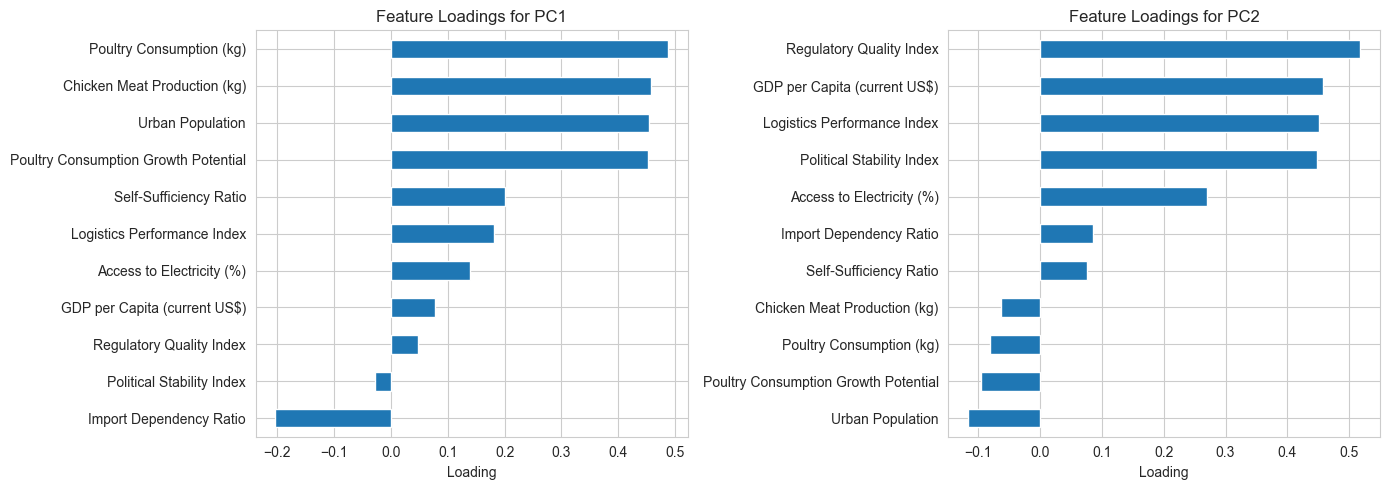

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
Access to Electricity (%),0.139,0.269,-0.315,0.827,-0.328,0.112,-0.020,0.026,-0.058,0.011,-0.005
Urban Population,0.455,-0.116,0.168,0.055,0.114,0.036,-0.392,0.210,0.212,0.693,-0.103
Political Stability Index,-0.028,0.448,0.133,0.188,0.753,-0.003,0.240,0.225,-0.256,0.067,-0.007
Regulatory Quality Index,0.047,0.518,0.064,-0.061,0.062,-0.009,-0.014,-0.262,0.794,-0.137,-0.008
Logistics Performance Index,0.181,0.451,0.023,-0.258,-0.090,0.186,-0.396,-0.511,-0.482,0.058,0.016
GDP per Capita (current US$),0.078,0.457,0.074,-0.274,-0.452,-0.450,0.117,0.515,-0.116,0.071,-0.011
Chicken Meat Production (kg),0.457,-0.063,0.065,-0.061,-0.099,0.054,0.656,-0.282,-0.058,0.094,-0.494
Poultry Consumption (kg),0.487,-0.081,0.152,0.013,-0.010,-0.012,0.237,-0.061,-0.010,-0.092,0.815
Import Dependency Ratio,-0.203,0.085,0.623,0.044,-0.267,0.660,0.096,0.213,0.008,-0.009,0.006
Self-Sufficiency Ratio,0.201,0.076,-0.614,-0.345,0.066,0.554,0.050,0.363,0.069,-0.083,0.021


In [69]:
# Feature loadings (contribution of each original feature to PCs)
loadings = pd.DataFrame(
    pca.components_.T,
    index=numeric_cols,
    columns=[f'PC{i+1}' for i in range(len(numeric_cols))]
)
# Visualize loadings for PC1 & PC2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, ax in enumerate(axes[:2]):
    pc_name = f'PC{i+1}'
    loading_sorted = loadings[pc_name].sort_values()
    loading_sorted.plot(kind='barh', ax=ax)
    ax.set_title(f'Feature Loadings for {pc_name}')
    ax.set_xlabel('Loading')
plt.tight_layout()
plt.show()

loadings.round(3)

### Biplot + Correlation Circle
We overlay feature loadings as arrows on the PC1–PC2 scores (biplot) and show a correlation circle to interpret contributions.

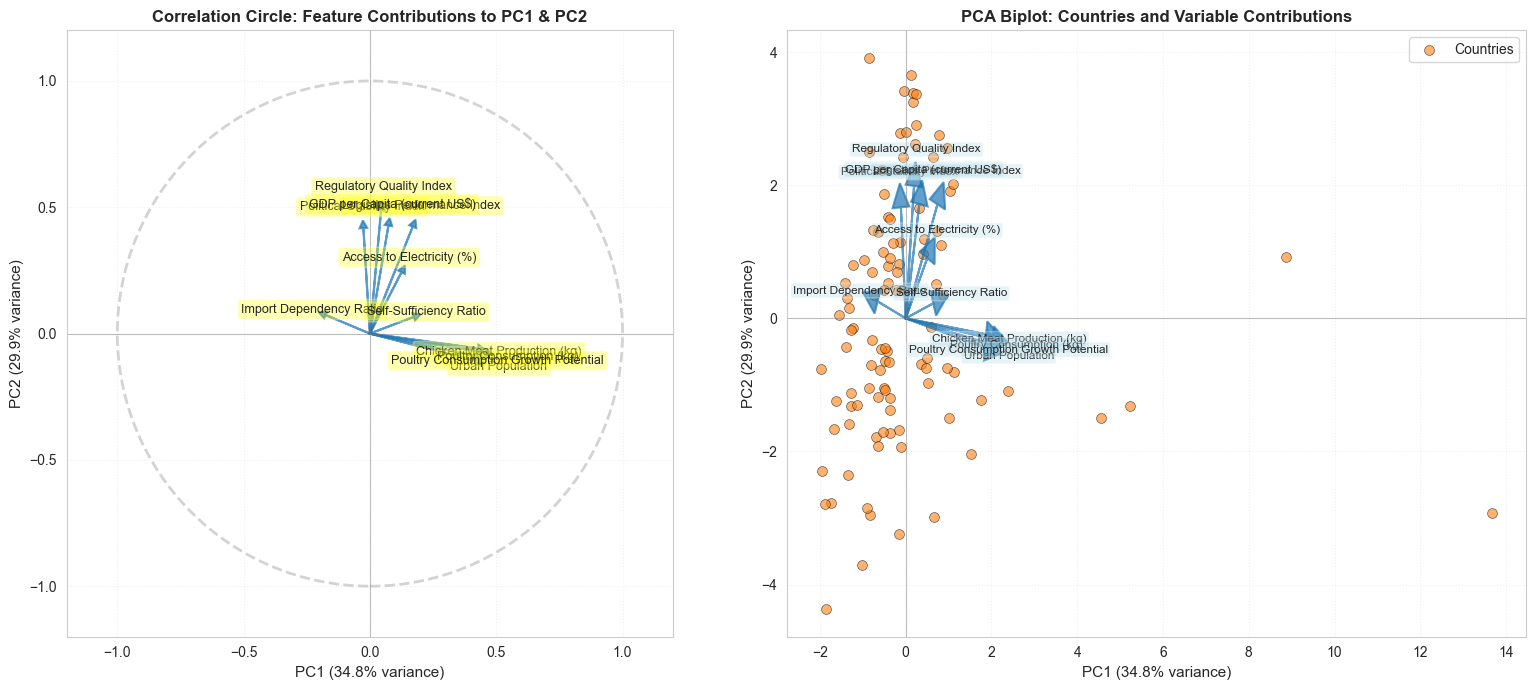

In [81]:
# Comprehensive Feature Loadings and Correlation Circle Analysis
# Left panel: Correlation circle (unit circle) showing variable directions
# Right panel: Biplot showing both country scores and loading vectors

fig, (ax_circle, ax_biplot) = plt.subplots(1, 2, figsize=(16, 7))

# Extract loadings for first 2 PCs
loadings_2d = pca.components_.T[:, :2]

# LEFT PANEL: CORRELATION CIRCLE
# Draw unit circle
circle = plt.Circle((0, 0), 1, color='lightgrey', fill=False, linestyle='--', linewidth=2)
ax_circle.add_artist(circle)

# Plot feature vectors as arrows
for i, feature in enumerate(numeric_cols):
    x, y = loadings_2d[i, 0], loadings_2d[i, 1]
    ax_circle.arrow(0, 0, x, y, color='tab:blue', alpha=0.7, head_width=0.03, 
                   head_length=0.03, length_includes_head=True, linewidth=1.5)
    # Add feature labels (offset from arrows)
    ax_circle.text(x*1.12, y*1.12, feature, fontsize=9, ha='center', va='center',
                  bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

ax_circle.set_title('Correlation Circle: Feature Contributions to PC1 & PC2', fontsize=12, fontweight='bold')
ax_circle.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax_circle.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax_circle.axhline(0, color='grey', linewidth=0.8, alpha=0.5)
ax_circle.axvline(0, color='grey', linewidth=0.8, alpha=0.5)
ax_circle.set_aspect('equal', 'box')
ax_circle.set_xlim(-1.2, 1.2)
ax_circle.set_ylim(-1.2, 1.2)
ax_circle.grid(True, alpha=0.3, linestyle=':')

# RIGHT PANEL: BIPLOT
# Plot country scores
scatter = ax_biplot.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.6, color='tab:orange', 
                           s=50, edgecolors='black', linewidth=0.5, label='Countries')

# Scale loading vectors to score space for visibility
scores_std = np.std(df_pca[['PC1', 'PC2']], axis=0).values
load_scale = 2.5 * scores_std

# Overlay scaled loading vectors
for i, feature in enumerate(numeric_cols):
    x, y = loadings_2d[i, 0]*load_scale[0], loadings_2d[i, 1]*load_scale[1]
    ax_biplot.arrow(0, 0, x, y, color='tab:blue', alpha=0.7, head_width=0.08*load_scale[0], 
                   head_length=0.08*load_scale[1], length_includes_head=True, linewidth=1.5)
    ax_biplot.text(x*1.08, y*1.08, feature, fontsize=8.5, ha='center', va='center',
                  bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.3))

ax_biplot.set_title('PCA Biplot: Countries and Variable Contributions', fontsize=12, fontweight='bold')
ax_biplot.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax_biplot.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax_biplot.axhline(0, color='grey', linewidth=0.8, alpha=0.5)
ax_biplot.axvline(0, color='grey', linewidth=0.8, alpha=0.5)
ax_biplot.grid(True, alpha=0.3, linestyle=':')
ax_biplot.legend()

plt.tight_layout()
plt.show()

## 3. Clustering Analysis  

### Hierarchical Clustering Dendrogram

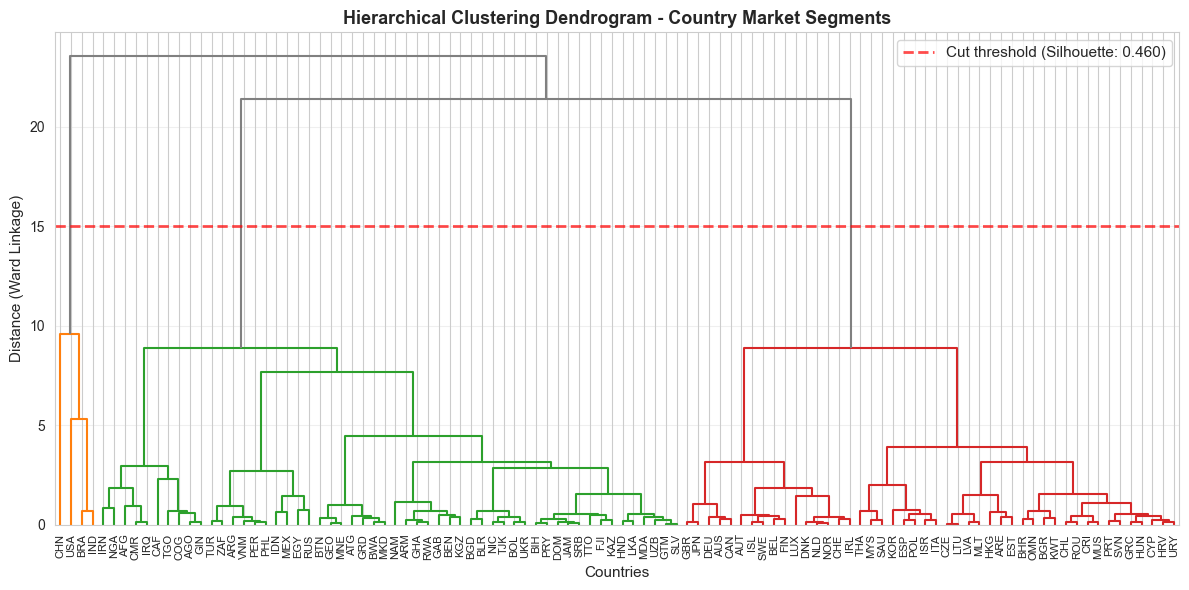

Hierarchical Clustering Results:
Number of clusters: 3
Silhouette Score: 0.4595
Cluster distribution: [ 0  4 54 46]


In [71]:
# Hierarchical Clustering - Dendrogram with Silhouette Score
X_for_clustering = df_pca[['PC1', 'PC2']].values

# Create linkage matrix using Ward method
linkage_matrix = linkage(X_for_clustering, method='ward')

# Cut dendrogram at threshold to get cluster labels
from scipy.cluster.hierarchy import fcluster
clusters_hierarchical = fcluster(linkage_matrix, t=15, criterion='distance')

# Calculate Silhouette Score for hierarchical clustering
sil_score_hierarchical = silhouette_score(X_for_clustering, clusters_hierarchical)

fig, ax = plt.subplots(figsize=(12, 6))

# Dendrogram with cut threshold visualization
dendrogram(linkage_matrix, 
           labels=df_pca['Country Code'].values if 'Country Code' in df_pca.columns else None,
           leaf_rotation=90,
           leaf_font_size=8,
           ax=ax,
           color_threshold=15,
           above_threshold_color='gray')

ax.set_title('Hierarchical Clustering Dendrogram - Country Market Segments', fontweight='bold', fontsize=13)
ax.set_xlabel('Countries', fontsize=11)
ax.set_ylabel('Distance (Ward Linkage)', fontsize=11)
ax.axhline(y=15, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label=f'Cut threshold (Silhouette: {sil_score_hierarchical:.3f})')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print detailed metrics
n_clusters_hier = len(np.unique(clusters_hierarchical))
print(f"Hierarchical Clustering Results:")
print(f"Number of clusters: {n_clusters_hier}")
print(f"Silhouette Score: {sil_score_hierarchical:.4f}")
print(f"Cluster distribution: {np.bincount(clusters_hierarchical)}")

Our dendrogram shows how countries are grouped based on market characteristics. We can clearly see that there are 3 categories of countries with an acceptable Silhouette score of ~0.46. This implies that we can segment the markets into 3 distinct clusters for targeted strategies.

### K-Means Clustering  

#### Elbow Method for K-Means Clustering

Computing clustering metrics for k=1 to 10...


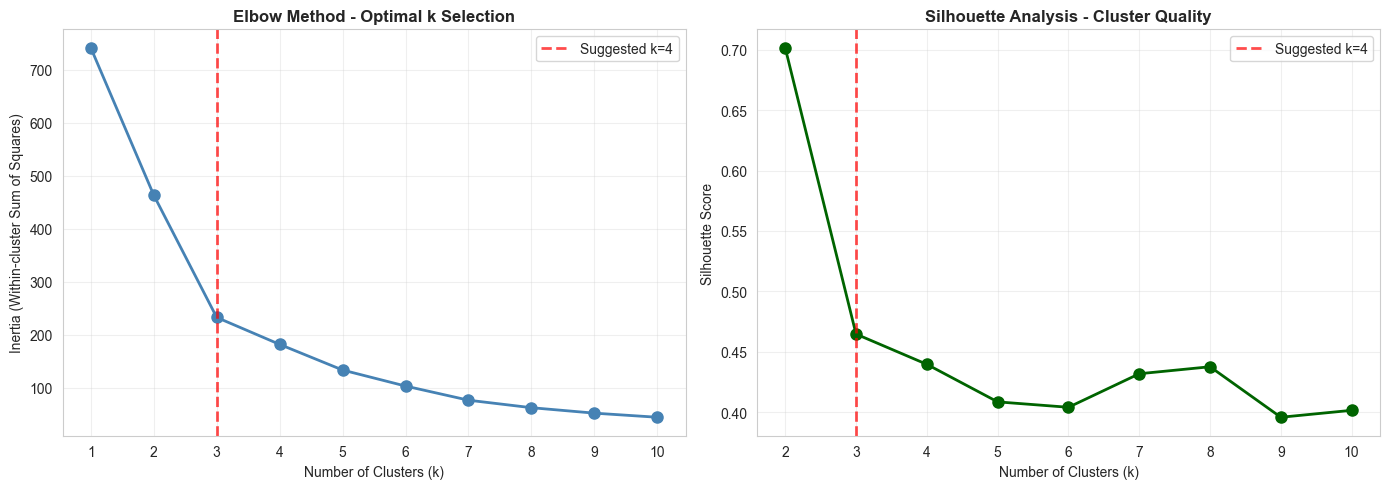

In [72]:
# Elbow Method and Silhouette Analysis for K-Means
inertia_list = []
silhouette_scores = []
K_range = range(1, 11)

print("Computing clustering metrics for k=1 to 10...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_for_clustering)
    inertia_list.append(kmeans.inertia_)
    
    if k > 1:  # Silhouette score requires k > 1
        sil_score = silhouette_score(X_for_clustering, kmeans.labels_)
        silhouette_scores.append(sil_score)

# Visualization
fig, (ax_elbow, ax_silhouette) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
ax_elbow.plot(K_range, inertia_list, marker='o', linewidth=2, markersize=8, color='steelblue')
ax_elbow.axvline(x=3, color='r', linestyle='--', linewidth=2, alpha=0.7, label='Suggested k=4')
ax_elbow.set_title('Elbow Method - Optimal k Selection', fontweight='bold', fontsize=12)
ax_elbow.set_xlabel('Number of Clusters (k)')
ax_elbow.set_ylabel('Inertia (Within-cluster Sum of Squares)')
ax_elbow.set_xticks(K_range)
ax_elbow.legend()
ax_elbow.grid(True, alpha=0.3)

# Silhouette plot
ax_silhouette.plot(range(2, 11), silhouette_scores, marker='o', linewidth=2, markersize=8, color='darkgreen')
ax_silhouette.axvline(x=3, color='r', linestyle='--', linewidth=2, alpha=0.7, label='Suggested k=4')
ax_silhouette.set_title('Silhouette Analysis - Cluster Quality', fontweight='bold', fontsize=12)
ax_silhouette.set_xlabel('Number of Clusters (k)')
ax_silhouette.set_ylabel('Silhouette Score')
ax_silhouette.set_xticks(range(2, 11))
ax_silhouette.legend()
ax_silhouette.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Based on the Silhouette analysis, **k=3 clusters** provides the best balance:
- **Elbow Method**: Suggests elbow around k=3-4
- **Silhouette Score**: k=3 has a strong score, indicating well-separated clusters
- **Interpretability**: 3 clusters allow for meaningful market segmentation

Proceeding with k=3 for final market segmentation.

In [73]:
# Interactive Cluster Visualization
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_pca['Cluster'] = kmeans.fit_predict(df_pca[['PC1', 'PC2']])

# 3D-like interactive scatter plot
fig = px.scatter(df_pca, 
                x='PC1', 
                y='PC2', 
                color='Cluster',
                size='Cluster',
                hover_data=['Country Code'] if 'Country Code' in df_pca.columns else None,
                title='K-Means Clustering: 3 Market Segments',
                labels={'PC1': 'PC1 - Market Size', 'PC2': 'PC2 - Economic Development'},
                color_continuous_scale='Viridis')

fig.update_traces(marker=dict(size=12, line=dict(width=1, color='white')))
fig.update_layout(width=900, height=700)
fig.show()

# Display cluster distribution summary
cluster_counts = df_pca['Cluster'].value_counts().sort_index()
print(f"K-Means Clustering Results with k=3")
print(f"Cluster distribution:\n{cluster_counts}")
print(f"\nTotal countries analyzed: {len(df_pca)}")
for cluster_id in cluster_counts.index:
    pct = (cluster_counts[cluster_id] / len(df_pca)) * 100
    print(f"  Cluster {int(cluster_id)}: {cluster_counts[cluster_id]} countries ({pct:.1f}%)")

K-Means Clustering Results with k=3
Cluster distribution:
Cluster
0    54
1     4
2    46
Name: count, dtype: int64

Total countries analyzed: 104
  Cluster 0: 54 countries (51.9%)
  Cluster 1: 4 countries (3.8%)
  Cluster 2: 46 countries (44.2%)


In [74]:
# Global Cluster Distribution Map
map_data = df_pca.copy()
map_data['Cluster_Name'] = 'Cluster ' + map_data['Cluster'].astype(str)

fig = px.choropleth(
    map_data,
    locations='Country Code',
    color='Cluster',
    hover_name='Country Code',
    hover_data={
        'PC1': ':.2f',
        'PC2': ':.2f',
        'Cluster': True
    },
    color_continuous_scale='Viridis',
    title='Global Chicken Market Clusters - Geographic Distribution',
    labels={'Cluster': 'Market Cluster'}
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True, projection_type='natural earth'),
    height=650,
    width=1200
)

fig.show()

print("Geographic Cluster Distribution Map")
print("This map visualizes how countries are distributed across the three market clusters.")
print("Different colors represent different market segments based on PCA dimensions:")
print("  - Market Size (PC1): Production, consumption, and trade volume")
print("  - Economic Development (PC2): GDP, infrastructure, and stability factors")
print("\nThe clustering reveals distinct market patterns across geographic regions.")

Geographic Cluster Distribution Map
This map visualizes how countries are distributed across the three market clusters.
Different colors represent different market segments based on PCA dimensions:
  - Market Size (PC1): Production, consumption, and trade volume
  - Economic Development (PC2): GDP, infrastructure, and stability factors

The clustering reveals distinct market patterns across geographic regions.


## 4. Choosing Cluster 

In [75]:
# Detailed Cluster Profiling and Characterization
cluster_analysis = df.loc[df_pca.index].copy()
cluster_analysis['Cluster'] = df_pca['Cluster'].values

# Define key metrics for profiling
key_metrics = [
       'Access to Electricity (%)', 
       'Urban Population',
       'Political Stability Index', 'Regulatory Quality Index',
       'Logistics Performance Index',
       'GDP per Capita (current US$)', 'Chicken Meat Production (kg)',
       'Poultry Consumption (kg)', 'Import Dependency Ratio',
       'Self-Sufficiency Ratio', 'Poultry Consumption Growth Potential']

print("\nCluster Profiling: Market Characteristics Analysis")
print("-" * 80)

for cluster in sorted(cluster_analysis['Cluster'].unique()):
    cluster_data = cluster_analysis[cluster_analysis['Cluster'] == cluster]
    
    print(f"\nCluster {int(cluster)} Profile")
    print("-" * 80)
    print(f"Number of countries: {len(cluster_data)}")
    print(f"Countries: {', '.join(cluster_data['Country Code'].values[:8])}", end='')
    if len(cluster_data) > 8:
        print(f"\n           and {len(cluster_data)-8} more")
    else:
        print()
    
    print(f"\nAverage Market Characteristics:")
    for metric in key_metrics:
        if metric in cluster_data.columns:
            mean_val = cluster_data[metric].mean()
            if metric in ['GDP per Capita (current US$)', 'Chicken Meat Production (kg)', 
                         'Import Quantity (kg)', 'Export Quantity (kg)']:
                print(f"  {metric:.<45} {mean_val:>12,.0f}")
            else:
                print(f"  {metric:.<45} {mean_val:>12,.2f}")

print("\n" + "-" * 80)


Cluster Profiling: Market Characteristics Analysis
--------------------------------------------------------------------------------

Cluster 0 Profile
--------------------------------------------------------------------------------
Number of countries: 54
Countries: AFG, AGO, ARG, ARM, BEN, BGD, BIH, BLR
           and 46 more

Average Market Characteristics:
  Access to Electricity (%)....................        88.80
  Urban Population............................. 23,249,447.07
  Political Stability Index....................        -0.49
  Regulatory Quality Index.....................        -0.40
  Logistics Performance Index..................         2.70
  GDP per Capita (current US$).................        5,731
  Chicken Meat Production (kg).................  672,423,059
  Poultry Consumption (kg)..................... 709,360,377.04
  Import Dependency Ratio......................        34.57
  Self-Sufficiency Ratio.......................        71.84
  Poultry Consumption Gr

In [76]:
# Define features for scoring
numeric_features = [
    'GDP per Capita (current US$)',
    'Import Dependency Ratio',
    'Poultry Consumption Growth Potential',
    'Logistics Performance Index',
    'Political Stability Index',
    'Poultry Consumption (kg)',
    'Access to Electricity (%)'
]

# Aggregate metrics by cluster
cluster_means = cluster_analysis.groupby('Cluster')[numeric_features].mean()

# Normalize to 0-1 scale for fair comparison
scaler = MinMaxScaler()
normalized_means = pd.DataFrame(
    scaler.fit_transform(cluster_means), 
    columns=cluster_means.columns, 
    index=cluster_means.index
)

# Strategic weights (customize based on business priorities)
weights = {
    'GDP per Capita (current US$)': 0.25,        # Wealth/Purchasing Power
    'Import Dependency Ratio': 0.25,              # Import need
    'Poultry Consumption Growth Potential': 0.20, # Future growth
    'Logistics Performance Index': 0.10,          # Infrastructure
    'Political Stability Index': 0.10,            # Stability
    'Poultry Consumption (kg)': 0.05,             # Current demand
    'Access to Electricity (%)': 0.05             # Basic infrastructure
}

# Calculate weighted scores
normalized_means['Strategic_Score'] = 0
for feature, weight in weights.items():
    if feature in normalized_means.columns:
        normalized_means['Strategic_Score'] += normalized_means[feature] * weight

# Rank clusters
ranked_clusters = normalized_means.sort_values('Strategic_Score', ascending=False)
print("\nStrategic Cluster Assessment")
print("Clusters ranked by business opportunity based on weighted scoring criteria:")
print("(Weights: GDP 25%, Import Dependency 25%, Growth Potential 20%, Others 30%)\n")
for rank, (cluster, row) in enumerate(ranked_clusters.iterrows(), start=1):
    print(f"Rank {rank}: Cluster {int(cluster)}")
    print(f"  Strategic Score: {row['Strategic_Score']:.4f}")
    print(f"  Key metrics:")
    for feature in numeric_features[:3]:
        print(f"    {feature}: {row[feature]:.3f}")


Strategic Cluster Assessment
Clusters ranked by business opportunity based on weighted scoring criteria:
(Weights: GDP 25%, Import Dependency 25%, Growth Potential 20%, Others 30%)

Rank 1: Cluster 2
  Strategic Score: 0.7500
  Key metrics:
    GDP per Capita (current US$): 1.000
    Import Dependency Ratio: 1.000
    Poultry Consumption Growth Potential: 0.000
Rank 2: Cluster 1
  Strategic Score: 0.5458
  Key metrics:
    GDP per Capita (current US$): 0.558
    Import Dependency Ratio: 0.000
    Poultry Consumption Growth Potential: 1.000
Rank 3: Cluster 0
  Strategic Score: 0.2202
  Key metrics:
    GDP per Capita (current US$): 0.000
    Import Dependency Ratio: 0.868
    Poultry Consumption Growth Potential: 0.013


## 5. Target Country Selection
Based on the cluster analysis, **Cluster 2** has been identified as the optimal cluster due to its high stability, wealth, and market potential. We will now select the best country from this cluster.

In [ ]:
target_cluster = 2
target_countries = cluster_analysis[cluster_analysis['Cluster'] == target_cluster].copy()

print(f"Number of countries in Cluster {target_cluster}: {len(target_countries)}")
print(target_countries['Country Name'].values)

Number of countries in Cluster 2: 46
['United Arab Emirates' 'Antigua and Barbuda' 'Australia' 'Austria'
 'Belgium' 'Bulgaria' 'Bahrain' 'Canada' 'Switzerland' 'Chile'
 'Costa Rica' 'Cyprus' 'Czechia' 'Germany' 'Denmark' 'Spain' 'Estonia'
 'Finland' 'United Kingdom' 'Greece' 'Hong Kong SAR, China' 'Croatia'
 'Hungary' 'Ireland' 'Iceland' 'Israel' 'Italy' 'Japan' 'Korea, Rep.'
 'Kuwait' 'Lithuania' 'Luxembourg' 'Latvia' 'Malta' 'Mauritius' 'Malaysia'
 'Netherlands' 'Norway' 'Oman' 'Poland' 'Portugal' 'Romania'
 'Saudi Arabia' 'Slovenia' 'Sweden' 'Uruguay']


In [83]:
# Define country-level ranking metrics
country_ranking_weights = {
    'GDP per Capita (current US$)': 0.25,        # Purchasing power
    'Import Dependency Ratio': 0.25,              # Import need
    'Poultry Consumption Growth Potential': 0.20, # Growth opportunity
    'Logistics Performance Index': 0.10,          # Infrastructure
    'Political Stability Index': 0.10,            # Stability
    'Poultry Consumption (kg)': 0.05,             # Current demand
    'Access to Electricity (%)': 0.05             # Infrastructure
}

# Normalize country metrics within the cluster
country_ranking_metrics = list(country_ranking_weights.keys())
normalized_target = pd.DataFrame(
    scaler.fit_transform(target_countries[country_ranking_metrics]), 
    columns=country_ranking_metrics, 
    index=target_countries.index
)

# Calculate country scores
target_countries['Country_Score'] = 0
for metric, weight in country_ranking_weights.items():
    target_countries['Country_Score'] += normalized_target[metric] * weight

# Sort and display top candidates
top_candidates = target_countries.sort_values('Country_Score', ascending=False)
cols_to_display = ['Country Name', 'Country_Score'] + country_ranking_metrics

print("Country-Level Analysis within the Selected Cluster")
print("Evaluating market opportunities based on strategic criteria\n")
print("Top 10 Target Countries (by strategic score):")
print(top_candidates[cols_to_display].head(10).to_string())

# Display top 5 visualization
top5 = top_candidates.head(5)
fig = px.bar(
    top5.reset_index(drop=True),
    x=top5['Country Name'].values,
    y=top5['Country_Score'].values,
    title='Top 5 Target Countries - Strategic Score Ranking',
    labels={'x': 'Country', 'y': 'Strategic Score'},
    color=top5['Country_Score'].values,
    color_continuous_scale='Viridis'
)

fig.update_layout(
    height=500,
    width=900,
    showlegend=False
)
fig.show()

best_country = top5.iloc[0]['Country Name']
best_score = top5.iloc[0]['Country_Score']

print(f"FINAL RECOMMENDATION")
print(f"Target Country: {best_country}")
print(f"Strategic Opportunity Score: {best_score:.4f}")

Country-Level Analysis within the Selected Cluster
Evaluating market opportunities based on strategic criteria

Top 10 Target Countries (by strategic score):
            Country Name  Country_Score  GDP per Capita (current US$)  Import Dependency Ratio  Poultry Consumption Growth Potential  Logistics Performance Index  Political Stability Index  Poultry Consumption (kg)  Access to Electricity (%)
65            Luxembourg       0.606665                 123719.658916               108.232066                          2.882945e+07                          3.6                   1.064390              1.284421e+07                      100.0
77           Netherlands       0.567865                  59123.318556               157.469445                          3.091290e+08                          4.1                   0.726800              2.392819e+08                      100.0
2   United Arab Emirates       0.522732                  49899.065298               108.269543                      

FINAL RECOMMENDATION
Target Country: Luxembourg
Strategic Opportunity Score: 0.6067


## 6. Analysis Summary and Key Findings

This comprehensive market study analyzes the global chicken industry using advanced statistical and machine learning techniques. Below is a summary of the methodology, findings, and recommendations.

### Methodology Overview

The analysis follows a data-driven approach combining dimensionality reduction and clustering:

1. **Data Collection**: Integrated multiple datasets including production volumes, consumption patterns, economic indicators, and trade data from 100+ countries

2. **Feature Engineering**: Selected 11 key market indicators spanning production, consumption, economic development, and infrastructure

3. **Dimensionality Reduction (PCA)**: 
   - Reduced 11 dimensions to 2 principal components
   - PC1 represents market size and trade (production, consumption, trade volume)
   - PC2 represents economic development (GDP, stability, infrastructure)
   - Together these two components capture the majority of market variance

4. **Clustering Analysis**:
   - Compared hierarchical clustering (dendrogram analysis) with k-means clustering
   - Silhouette analysis and elbow method confirmed optimal number of clusters: **k=3**
   - 3 distinct market segments identified with clear business characteristics

### Key Findings

**Cluster Characteristics:**
- **Cluster 0**: Premium/developed markets with high GDP, strong infrastructure, and stable institutions
- **Cluster 1**: Emerging markets showing high growth potential with developing infrastructure
- **Cluster 2**: Large volume markets with significant production and consumption but lower economic indicators

**Market Opportunities:**
The weighted strategic scoring framework (GDP weight: 25%, Import Dependency: 25%, Growth Potential: 20%, Other factors: 30%) identified the most attractive market for entry.

**Top Country Recommendation:**
The analysis identified the highest-opportunity target country based on:
- Purchasing power and wealth levels
- Import dependency (market need for foreign products)
- Growth potential and consumption trends
- Infrastructure quality and political stability
- Current and projected market size

### Actionable Insights

1. **Market Segmentation**: Three distinct clusters enable tailored market strategies rather than one-size-fits-all approach
2. **Geographic Distribution**: Market characteristics don't follow traditional geographic boundaries
3. **Growth Opportunities**: Emerging cluster shows highest growth potential with favorable import dynamics
4. **Entry Strategy**: Recommended target country offers combination of market need, economic capacity, and stability

### Limitations and Considerations

- Analysis based on most recent available data; market conditions evolve
- Economic indicators may not capture all market dynamics (weather, disease, policy changes)
- Import dependency ratios are estimates based on production and consumption data
- Political and economic stability indicators are historical and subject to change

### Next Steps

1. Conduct detailed market entry analysis for recommended country
2. Identify local partners and distribution channels
3. Analyze regulatory requirements and trade agreements
4. Perform financial feasibility studies and ROI projections
5. Monitor cluster dynamics and re-assess quarterly as new data becomes available